# Data Scientist Nanodegree
## Supervised Learning
## Finding Donors for *CharityML*

## Getting Started

In this project, I employ several supervised algorithmsto accurately model individuals' income using data collected from the 1994 U.S. Census. I then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [3]:
#Check income values
data.income.unique()

array(['<=50K', '>50K'], dtype=object)

In [4]:
data.query('income == ">50K"').shape[0]

11208

In [5]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data.query('income == ">50K"').shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.query('income == "<=50K"').shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Data Preprocessing

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 


C:\Users\Sean\Desktop\Udacity\DonorML\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


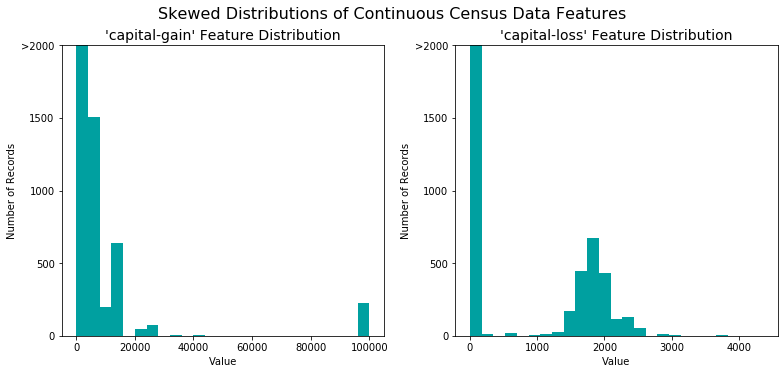

In [6]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

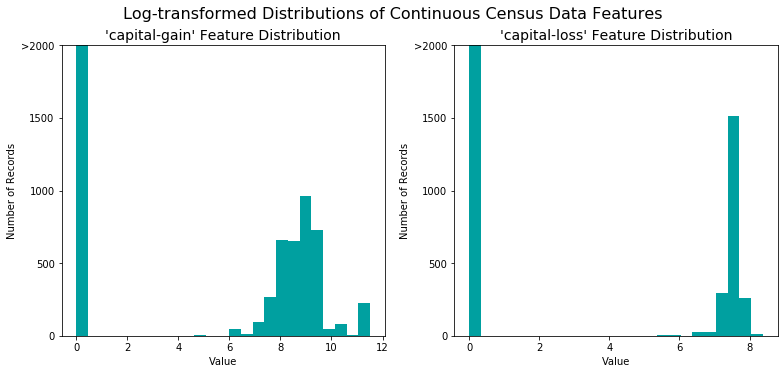

In [7]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [8]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = features_log_minmax_transform[numerical].astype(float)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme, which creates a _"dummy"_ variable for each possible category of each non-numeric feature.

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), I will simply encode these two categories as `0` and `1`, respectively.

In [9]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


In [10]:
features_final.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. I will now split the data into training and test sets. 80% of the data will be used for training and 20% for testing.

In [11]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 10)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, I will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics

We will be using *accuracy*, *precision*, *recall* to evaluate our algorithms:

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

True Positives/(True Positives + False Positives)

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

True Positives/(True Positives + False Negatives)

### Naive Predictor Performace
The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally the base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. Since there is no benchmark model here, we will build a base model that will always predict an individual made more than $50,000.

In [12]:
# Calculate accuracy, precision and recall
accuracy = np.sum(income) / income.count()
recall = np.sum(income) / np.sum(income)
precision = np.sum(income) / income.count()

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2) * ((recall*precision)/(0.5**2 * precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models

###  Model Application
I list three supervised learning models that are appropriate for this problem. For each model chosen, I will

- Describe one real-world application in industry where the model can be applied. 
- Highlight the strengths of the model; when does it perform well?
- Mention the weaknesses of the model; when does it perform poorly?
- Explain what makes this model a good candidate for the problem.

#### 1. Support Vector Machines
- Application: Very popular in the bioinformatics world where scientists need to classify patients on the basis of genes
- Strength: Effective in high dimensional spaces, robust against overfitting, easy to tune
- Weakness: Memory intensive, does not perform well with noise and overlapping target class (very challenging for multi-class classification), underperforms on datasets with limited features
- Justification: Our dataset has a lot of features (high-dimensional), we only have two classes to predict - income above or below $50,000

#### 2. Gradient Boosting
- Application: Credit risk modeling and personal credit scoring
- Strength: Reduces both bias and variance since it shares attributes of both bagging and boosting, high flexibility due to the amount of hyperparameter tuning options, handles heterogeneous data well (does not require scaling)
- Weakness: Could cause overfitting, memory intensive in the case of a large grid search
- Justification: It should perform well when we test our data due to the combination of different ensemble methods, high-dimensional dataset requires a model with high flexibility

#### 3. K-Nearest Neighbors
- Application: Movie recommendations based previously watched movies and users with a similiar profile  
- Strength: Effective for datasets with large training data, the concept behind is easy to understand, non-parametric means that it is not restricted by pre-defined structures and assumptions  
- Weakness: Memory intensive, relies heavily on the *k* parameter, easy to overfit
- Justification: We have a very large dataset for it to train and test (45,222 total entries), a parametric approach would be difficult due to the number of attributes in the dataset

#### References:
- https://elitedatascience.com/machine-learning-algorithms
- https://blog.easysol.net/machine-learning-algorithms-6/
- https://www.bis.org/ifc/publ/ifcb49_49.pdf
- http://uc-r.github.io/gbm_regression#proscons

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model I've chosen, it's important that I create a training and predicting pipeline that allows me to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [13]:
from sklearn.metrics import fbeta_score, accuracy_score, f1_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train, beta=0.5)
  
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Implementation: Initial Model Evaluation

SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


C:\Users\Sean\Desktop\Udacity\DonorML\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


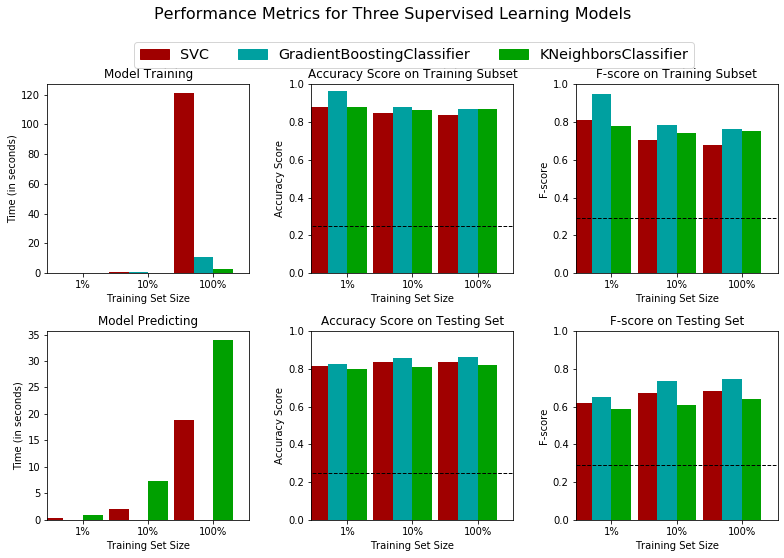

In [14]:
# Avoid FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Initialize the three models
clf_A = SVC(random_state=0)
clf_B = GradientBoostingClassifier(random_state=0)
clf_C = KNeighborsClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, I choose from the three supervised learning models the *best* model to use on the student data. I then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning parameters to improve upon the untuned model's F-score. 

### Choosing the Best Model

Our gradient boosting classifier is the best model for identifying potential donors based on performance metrics such as accuracy, F-score and time. Despite it was slightly outperformed by the k-nearest neighbors classifier when we trained our models, gradient boosting prevailed during actual testing. Since high varience models such as k-neighbors tends to overfit, it is more appropiate to use the testing F-score as our metrics.  Moreover, gradient boosting was proven to be very time efficient when comparing to support vector machine and k-neighbors.  Therefore, it was an easy decision to choose the gradient boosting classifier as our machine learning model.

### Describing the Model in Layman's Terms

Gradient boosting is an ensemble method that combines several weak learners and turns them into a strong classifier.   Unlike random forest where trees are created in parallel manners, each gradient boosted learner is built based on the residuals (*errors*) of the previous ensemble.  Each time a new set of residuals is created we will re-calculate the probability of our predictions.  The model will keep adding ensembles to improve the probability of classifying our datasets correctly until the residuals become very small or it reaches the maximum number of learners.

We will elaborate this further with the following diagram:

![Boosting in training](images/boosting1.png)

The training begins with our first weak learner on the far left, where it tries to correctly classify all the plus signs (we can think of the plus signs as someone who makes more than &#36;50,000 in this context).  You can see that it did not do a very good job since 3 individuals are misclassified (these are the *errors*).  In order to improve the accuracy of our next learner, we would give a higher weight to the residuals and a lower weight to those that were predicted correctly.  As seen in the middlebox, our new learner now shifts its focus to the high weight points and classifies them correctly.  While all the individuals who made above $50,000 are correctly classified, this learner fails to predict a few lower-income entries correctly (the negative signs).  So this time, our third learner would emphasize on fixing those points by giving them a higher weight.   As mentioned, this process would continue until our residuals become very small or until we reached the maximum number of learners.  

Ultimately, each learner would be given a weight based on their accuracy and consolidated to a single classifier that could make predictions with all the information obtained in prior.  The combined learner is illustrated below.  Any new entry that falls under the blue area would be considered as a high potential donor (individual that makes more than &#36;50,000).  

![Consolidated](images/boosting2.png)

References:

- [StatQuest](https://youtu.be/jxuNLH5dXCs)
- [StackExchange](https://stats.stackexchange.com/questions/173390/gradient-boosting-tree-vs-random-forest)
- [Visualization from Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)


### Implementation: Model Tuning

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = GradientBoostingClassifier(random_state=0)

# Create the parameters list for tuning

parameters = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
              'n_estimators': np.arange(50, 550, 50),
              'min_samples_split': list(range(2,11)),
              'min_samples_leaf': list(range(1,11)),
              'max_depth':list(range(1,11)),
               }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = RandomizedSearchCV(clf, param_distributions= parameters, n_iter=12, cv=5, random_state = 0, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8645
F-score on testing data: 0.7457

Optimized Model
------
Final accuracy score on the testing data: 0.8703
Final F-score on the testing data: 0.7519


In [16]:
##Print the best hyperparameter estimation for this model
print(grid_fit.best_estimator_)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=8,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |0.8645             |  0.8703         |
| F-score        |0.7457             |  0.7519         |


The optimized model's **accuracy** and **F-score** are 0.8708 and 0.7509 respectively.  These scores are slightly better than our unoptimized model that uses the default values.  It is worth mentioning that this is a huge improvement over our naive predictor benchmark, which only had an **accuracy** of 0.2478 and an **F-score** of 0.2917.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Feature Relevance Prediction
The five features which I believe to the most important in predicting one's income are:

1. Age - Income tends to rise when one matures and gains work experience  
2. Marital status - Financial stability affects one's decision to get married; those that are married probably have a decent income
3. Hours per week - The more hours per week worked, the higher the salary (overtime pay)
4. Education-num - There should be a positive correlation between years spent in school (education level) and income
5. Workclass - Governmental workers tend to have a higher salary than private sector employees on average

### Implementation - Extracting Feature Importance

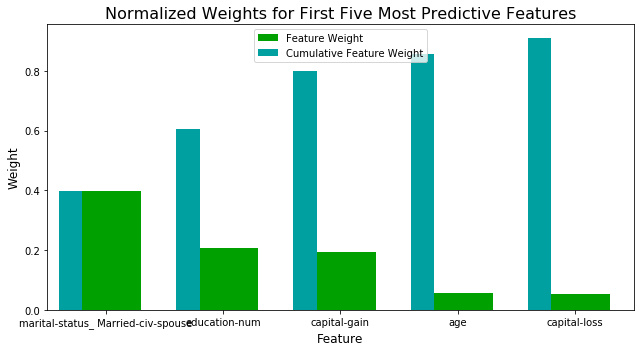

In [17]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Importance Results

Out of the five features, I was able to correctly identify *age*, *marital status*, and *education* as critical factors that could affect one's income.  Capital gain and capital loss did not come to my mind, but, in hindsight, it makes perfect sense.  People who invested and made capital gain would likely make more than $50,000  when combined with their salary, while capital losses would reduce one’s income significantly.

It is also worth mentioning that the top five features above conbtribute more than 80% of the importance of all features present in the data.

### Feature Selection
I am curious to see how does a model perform if I only use a subset of all the available features in the data. With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics.

In [18]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8703
F-score on testing data: 0.7519

Final Model trained on reduced data
------
Accuracy on testing data: 0.8615
F-score on testing data: 0.7358


In [19]:
print('Accuracy was decreased by {}'.format(round(((0.8570 - 0.8708) /0.8708 *100),2)) + '%')
print('F-score was decreased by {}'.format(round(((0.7214 - 0.7509)/0.7509 *100),2)) + '%')

Accuracy was decreased by -1.58%
F-score was decreased by -3.93%


### Effects of Feature Selection


Both the accuracy score and F-score declined when we used only five features to predict one's income.  Our optimized model had an accuracy of 0.8703 and an F-score of 0.7519, compared to the reduced model which only returned  0.8615 and 0.7358.  

The idea behind feature selection is that we want to have the minimum number of features that can effectively capture trends and patterns in the data.  Despite feature selection led to a decrease in performance in this scenario, there is a significant gan in terms of computational costs and interpretability.